In [1]:
import numpy as np
import itertools
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Categorical
from typing import Type, Any, Callable, Union, List, Optional
import gym
import gym_Aircraft
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [3]:
class FClayer(nn.Module):
    def __init__(self, innodes: int, nodes: int):
        super(FClayer, self).__init__()
        self.fc=nn.Linear(innodes,nodes)
        self.act=nn.LeakyReLU(0.2, inplace=True)
    def forward(self, x: Tensor) -> Tensor:
        out=self.fc(x)
        out=self.act(out)
        return out
class WaveNET(nn.Module):
    def __init__(self, block: Type[Union[FClayer]], planes: List[int], nodes: List[int], num_classes: int = 3
                ) -> None:
        super(WaveNET, self).__init__()
        self.innodes=5
        
        self.layer1=self._make_layer(block, planes[0], nodes[0])
        self.layer2=self._make_layer(block, planes[1], nodes[1])
        self.layer3=self._make_layer(block, planes[2], nodes[2])
        
        self.fin_fc=nn.Linear(self.innodes,num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    
    def _make_layer(self, block: Type[Union[FClayer]], planes: int, nodes: int) -> nn.Sequential:

        layers = []
        layers.append(block(self.innodes, nodes))
        self.innodes = nodes
        for _ in range(1, planes):
            layers.append(block(self.innodes, nodes))

        return nn.Sequential(*layers)

        
    def _forward_impl(self, x: Tensor) -> Tensor:
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fin_fc(x)
        
        return x
    
    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [4]:
actor_model = torch.load("./Custom_model_fin")
critic_model = torch.load("./Custom_model_fin")
mean = np.load('mean_test.npy')
std = np.load('std_test.npy')

/home/kunwoopark/.local/lib/python3.6/site-packages/torch/serialization.py:625: UserWarning: Couldn't retrieve source code for container of type WaveNET. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/home/kunwoopark/.local/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kunwoopark/.local/lib/python3.6/site-packages/torch/serialization.py:625: UserWarning: Couldn't retrieve source code for container of type FClayer. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/home/kunwoopark/.local/lib/python3.6/site-packages/torch/serialization.p

In [5]:
num_final_nodes = critic_model.fin_fc.in_features
critic_model.fin_fc = nn.Linear(num_final_nodes, 1)

In [6]:
num_final_nodes = actor_model.fin_fc.in_features
num_output_nodes = actor_model.fin_fc.out_features
actor_model.fin_fc = nn.Sequential(nn.Linear(num_final_nodes, num_output_nodes), nn.Softmax(dim=-1))

In [7]:
class ActorCritic(nn.Module):
    def __init__(self, actor_model, critic_model):
        super(ActorCritic, self).__init__()

        # actor
        self.action_layer = actor_model
        
        # critic
        self.value_layer = critic_model
        
    def forward(self):
        raise NotImplementedError
        
    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device) 
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))
        
        return action.item()
    
    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        state_value = self.value_layer(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy
        
class PPO:
    def __init__(self, actor_model, critic_model, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(actor_model, critic_model).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(actor_model, critic_model).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def update(self, memory):   
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())
                
            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())


In [8]:
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad
def plot(epi_idx, rewards, total_res):
    plt_res=total_res[-1]
    
    clear_output(True)
    plt.figure(figsize=(20,15))
    plt.subplot(411)
    plt.title('Episodes %s. reward: %s' % (epi_idx, rewards[-1]))
    plt.plot(rewards),plt.grid()
    
    plt.subplot(412)
    plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
    plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()
    plt.subplot(413)
    plt.plot(plt_res[:,10],label=r'$\{h}$')
    plt.ylabel(r'$h$ (m)'), plt.grid()
    plt.subplot(414)
    plt.plot(plt_res[:,1],label=r'$\{r}$')
    plt.ylabel(r'$r$ (m)'), plt.grid()
    
    plt.legend()
    plt.show()
    

In [9]:
############## Hyperparameters ##############
env_name = "acav-v0"
# creating environment
env = gym.make(env_name)
render = False
solved_reward = 5000         # stop training if avg_reward > solved_reward
log_interval = 100           # print avg reward in the interval
max_episodes = 100000        # max training episodes
max_timesteps = 300         # max timesteps in one episode
n_latent_var = 60           # number of variables in hidden layer
update_timestep = 2000      # update policy every n timesteps
lr = 0.002
betas = (0.9, 0.999)
gamma = 0.99                # discount factor
K_epochs = 4                # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
action_maintain_steps=10
random_seed = None
#############################################

if random_seed:
    torch.manual_seed(random_seed)
    env.seed(random_seed)

memory = Memory()
ppo = PPO(actor_model, critic_model, lr, betas, gamma, K_epochs, eps_clip)

# logging variables
running_reward = 0
avg_length = 0
timestep = 0

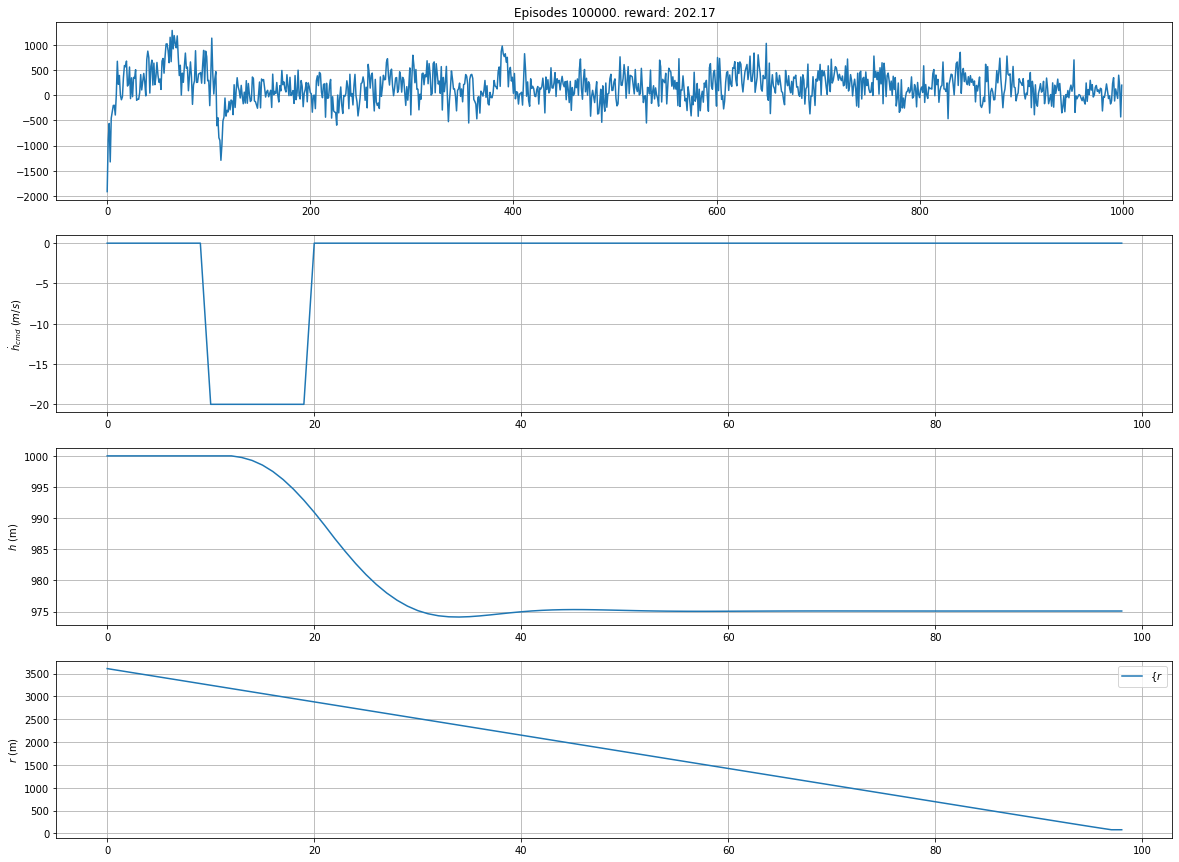

In [10]:
# training loop

rewards   = []
total_res=[]
for i_episode in range(1, max_episodes+1):
    epi_reward=0
    action_steps = action_maintain_steps
    
    state = env.reset()

    res_list=np.zeros(11)
    
    for t in range(max_timesteps):
        timestep += 1
        state = (state-mean)/std

        # make action maintained
        if action_steps == action_maintain_steps:
            action = ppo.policy_old.act(state, memory)
            action_steps = 0
        else:
            ppo.policy_old.act(state, memory)
            
        # Running policy_old:    
        state, reward, done, info = env.step(action)
        
        # count number of action steps
        action_steps += 1
        
        # save data to print
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list=info["info"]
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])

        # Saving reward and is_terminal:
        memory.rewards.append(reward)
        memory.is_terminals.append(done)

        # update if its time
        if timestep % update_timestep == 0:
            ppo.update(memory)
            memory.clear_memory()
            timestep = 0

        running_reward += reward
        epi_reward += reward
        if render:
            env.render()
        if done:
            res_list=np.delete(res_list,0,0)
            total_res.append(res_list)
            break

    avg_length += t

    # stop training if avg_reward > solved_reward
    if running_reward > (log_interval*solved_reward):
        print("########## Solved! ##########")
        torch.save(ppo.policy.state_dict(), './PPO_{}.pth'.format(env_name))
        break

    # logging
    if i_episode % log_interval == 0:
        avg_length = avg_length/log_interval
        running_reward = running_reward/log_interval
        rewards.append(running_reward)
        plot(i_episode,rewards,total_res)

        print('Episode {} \t avg length: {} \t run_reward: {} \t min_r: {} \t reward: {}'.format(i_episode, avg_length, running_reward,min(total_res[-1][:,1]),epi_reward), end="\r")
        running_reward = 0
        avg_length = 0

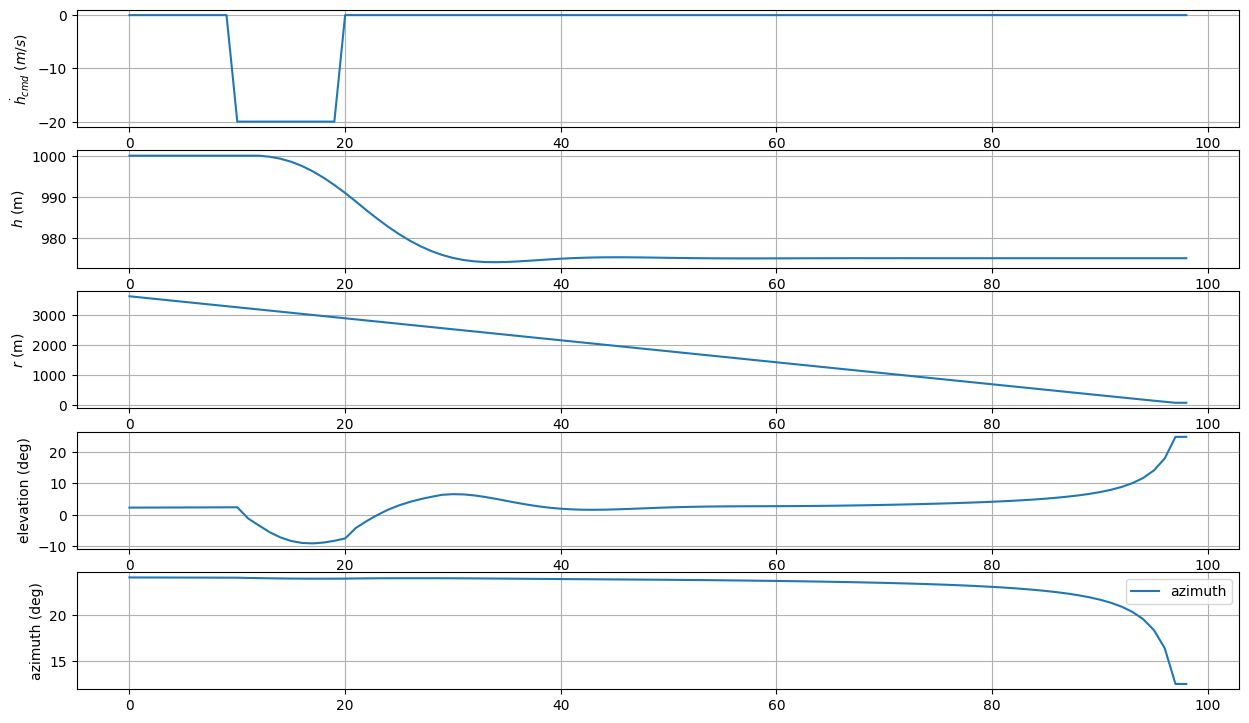

In [11]:
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[-1]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

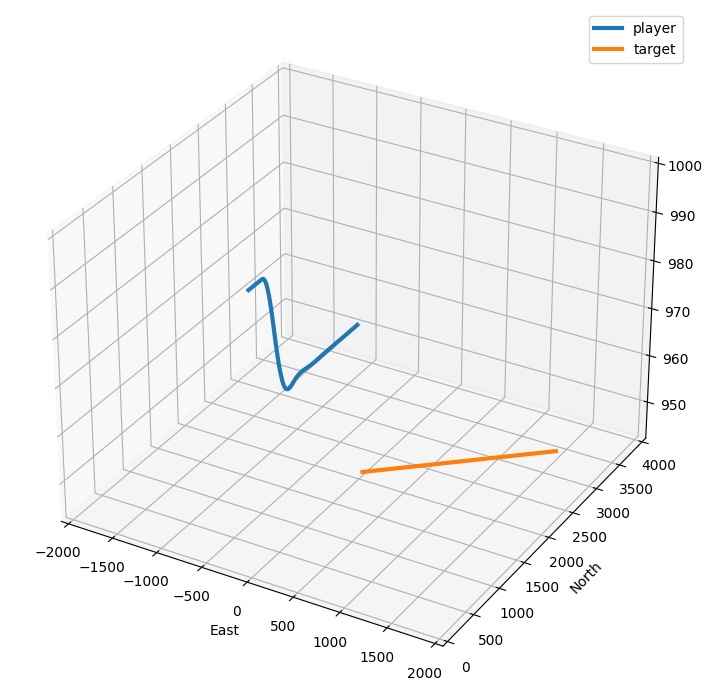

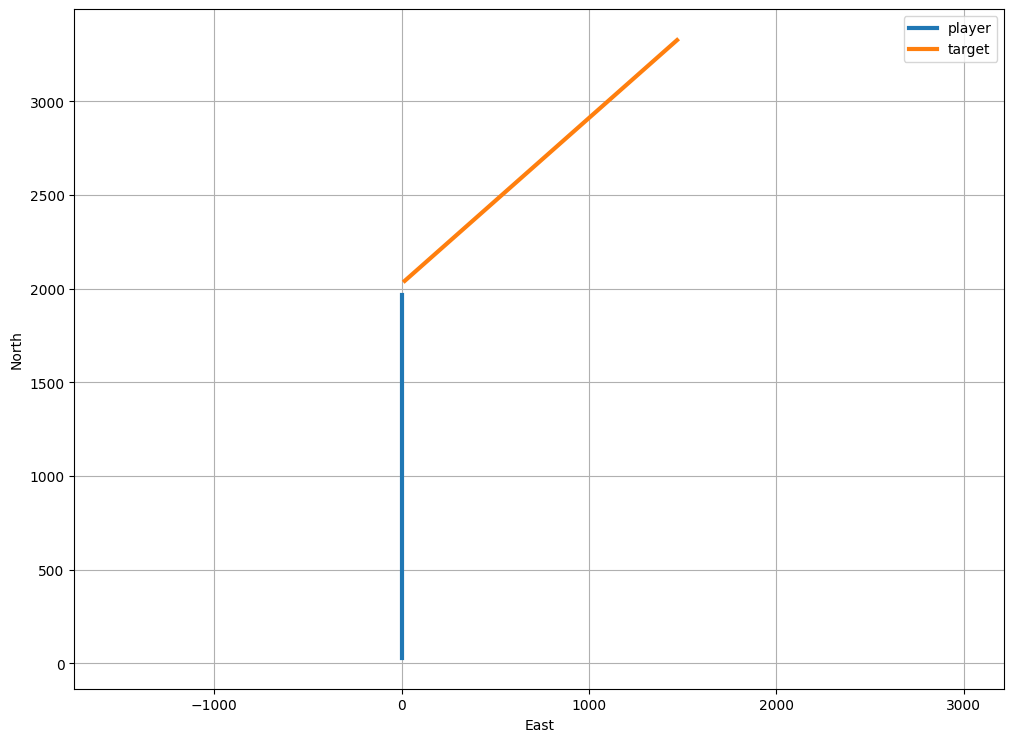

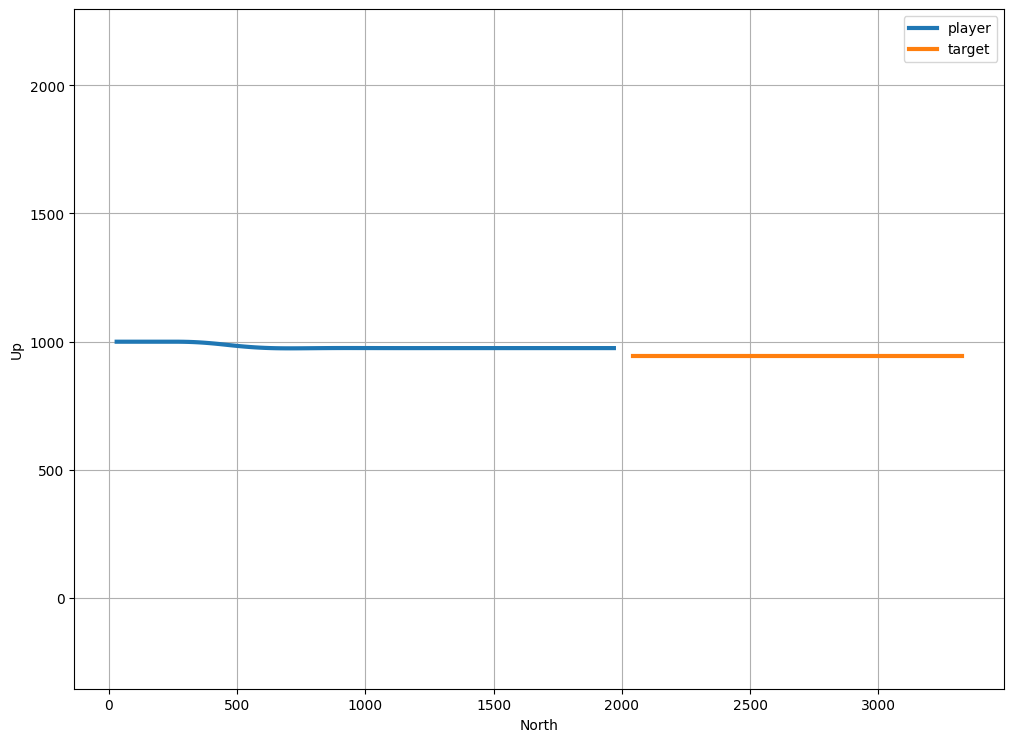

In [12]:
# trajectory plots

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()